In [10]:
import os
import pandas as pd

from pyannote.core import Segment, Annotation
from pyannote.metrics.diarization import DiarizationErrorRate
metric = DiarizationErrorRate()

In [11]:
def txt2annotation(path_txt, annotation=Annotation()):
    #check if file is txt of csv
    if path_txt.endswith('.txt'):
        with open(path_txt, 'r') as f:
            for line in f:
                if len(line) == 0:
                    continue
                start, end, speaker = line.split()
                speaker = speaker.lower()
                annotation[Segment(float(start), float(end))] = speaker
            return annotation
    elif path_txt.endswith('.csv'):
        diarization = pd.read_csv(path_txt)
        for index, row in diarization.iterrows():
            start = row['start [s]']
            end = row['end [s]']
            speaker = row['speaker']
            annotation[Segment(float(start), float(end))] = speaker
        return annotation

# Primero, una prueba sencilla

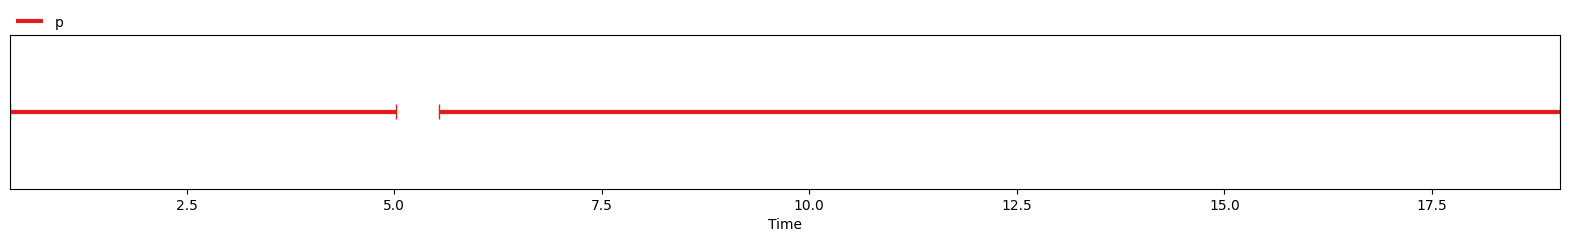

In [12]:
# reference annotation
reference_path = os.path.join('REDLAT', 'reference', 'ASW', 'REDLAT_AF111_CraftIm.txt')
reference = txt2annotation(reference_path, annotation=Annotation(uri='test'))
reference

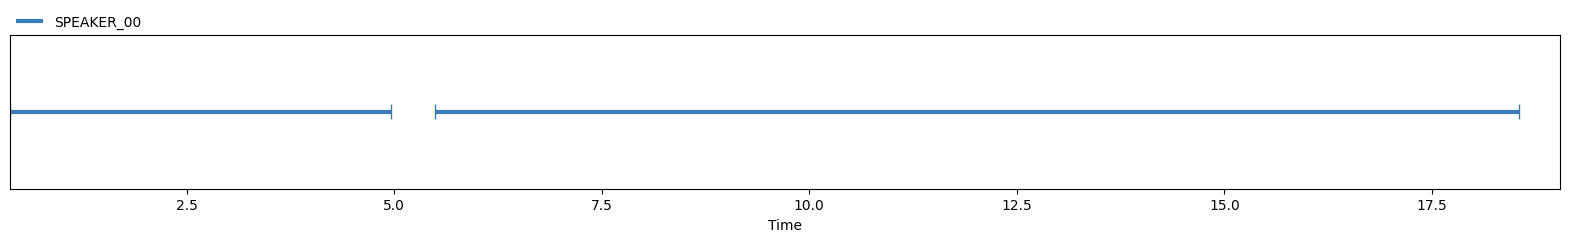

In [13]:
# hypothesis annotation
hypothesis_path = os.path.join('REDLAT', 'hypothesis', 'ASW', 'diarization', 'REDLAT_AF111_CraftIm_diarization.csv')
hypothesis = txt2annotation(hypothesis_path, annotation=Annotation(uri='test'))
hypothesis

In [14]:
# DER
metric(reference, hypothesis, detailed=True)

/home/aleph/diariziation_error_rate/.env/lib/python3.10/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(


{'confusion': 0.0,
 'missed detection': 0.5459630000000013,
 'false alarm': 0.4085310000000001,
 'total': 18.151432,
 'correct': 17.605469,
 'diarization error rate': 0.052585052242710185}

In [15]:
# full report and reset metric
report = metric.report(display=True)
metric.reset()

      diarization error rate total correct correct false alarm false alarm missed detection missed detection confusion confusion
                           %                     %                       %                                 %                   %
item                                                                                                                            
test                    5.26 18.15   17.61   96.99        0.41        2.25             0.55             3.01      0.00      0.00
TOTAL                   5.26 18.15   17.61   96.99        0.41        2.25             0.55             3.01      0.00      0.00


# Ahora obtengamos un DER para todos los pares reference - hypothesis de la base combinada

In [24]:
import warnings
warnings.filterwarnings("ignore")

count = 0
# find all txt files in reference directory
reference_dir = os.path.join('REDLAT', 'reference')
reference_files = [f for f in os.listdir(reference_dir) if f.endswith('.txt')]
# os walk to find all txt files in reference directory
for root, dirs, files in os.walk(reference_dir):
        for file in files:
            if file.endswith('.txt'): 
                try:
                    reference_path = (os.path.join(root, file))
                    annotation = Annotation(uri=file)
                    # print(reference_path)
                    reference = txt2annotation(reference_path, annotation)

                    # find corresponding hypothesis file
                    hypothesis_path = reference_path.replace('reference', 'hypothesis')
                    directory, filename = os.path.split(hypothesis_path)
                    hypothesis_path = os.path.join(directory, 'diarization', filename.replace('.txt', '_diarization.csv'))
                    annotation = Annotation(uri=file)
                    hypothesis = txt2annotation(hypothesis_path, annotation)

                    # compute DER
                    metric(reference, hypothesis, detailed=True)
                except:
                    # print('Error in file:', reference_path)
                    # print(reference_path)
                    # log reference_path to file
                    with open('error_log.txt', 'a') as f:
                        f.write(reference_path)
                        f.write('\n')
                    count += 1
                    # print(count)


# cumulative report

print(abs(metric))
report = abs(metric.report(display=True))
report.to_csv('DER_report.csv')
metric.reset() # reset metric for next iteration
print('Total number of files with errors:', count)

0.43755607854902917
                                 diarization error rate    total  correct correct false alarm false alarm missed detection missed detection confusion confusion
                                                      %                         %                       %                                 %                   %
item                                                                                                                                                           
REDLAT_BN00142_CraftIm.txt                        33.16    24.17    17.28   71.50        1.13        4.66             6.89            28.50      0.00      0.00
REDLAT_AF257_Phonological2.txt                    37.73    40.90    25.47   62.27        0.00        0.00            15.43            37.73      0.00      0.00
REDLAT_MA439_Phonological2.txt                    84.39    16.43     2.56   15.61        0.00        0.00             8.45            51.43      5.42     32.97
REDLAT_CU148_Semanti

In [25]:
# DER report based on PM code

codes = ['AF', 'BE', 'BN','CU', 'LO', 'MA','SL']

for code in codes:
    # find all txt files in reference directory
    reference_dir = os.path.join('REDLAT', 'reference')
    reference_files = [f for f in os.listdir(reference_dir) if f.endswith('.txt')]
    # os walk to find all txt files in reference directory
    for root, dirs, files in os.walk(reference_dir):
            for file in files:
                if file.endswith('.txt') and code in file:
                    try:
                        reference_path = (os.path.join(root, file))
                        annotation = Annotation(uri=file)
                        # print(reference_path)
                        reference = txt2annotation(reference_path, annotation)

                        # find corresponding hypothesis file
                        hypothesis_path = reference_path.replace('reference', 'hypothesis')
                        directory, filename = os.path.split(hypothesis_path)
                        hypothesis_path = os.path.join(directory, 'diarization', filename.replace('.txt', '_diarization.csv'))
                        annotation = Annotation(uri=file)
                        hypothesis = txt2annotation(hypothesis_path, annotation)

                        # compute DER
                        metric(reference, hypothesis, detailed=True)
                    except:
                        print('Error in file:', reference_path)


    # cumulative report

    print(abs(metric))
    report = abs(metric.report(display=True))
    report.to_csv(f'REDLAT/results/DER_report_{code}.csv')
    metric.reset() # reset metric for next iteration

0.3729756403764548
                               diarization error rate   total correct correct false alarm false alarm missed detection missed detection confusion confusion
                                                    %                       %                       %                                 %                   %
item                                                                                                                                                       
REDLAT_AF257_Phonological2.txt                  37.73   40.90   25.47   62.27        0.00        0.00            15.43            37.73      0.00      0.00
REDLAT_AF178_Phonological.txt                   61.54   27.07   11.00   40.63        0.59        2.17             7.59            28.05      8.48     31.32
REDLAT_AF111_Semantic.txt                       39.13   52.43   34.68   66.14        2.76        5.27             5.32            10.15     12.43     23.70
REDLAT_AF230_Semantic.txt                    

In [26]:
# DER report based on task code

codes = ['Phonological', 'CraftIm', 'Fugu','CraftDe', 'Semantic']

for code in codes:
    # find all txt files in reference directory
    reference_dir = os.path.join('REDLAT', 'reference')
    reference_files = [f for f in os.listdir(reference_dir) if f.endswith('.txt')]
    # os walk to find all txt files in reference directory
    for root, dirs, files in os.walk(reference_dir):
            for file in files:
                if file.endswith('.txt') and code in file:
                    try:
                        reference_path = (os.path.join(root, file))
                        annotation = Annotation(uri=file)
                        # print(reference_path)
                        reference = txt2annotation(reference_path, annotation)

                        # find corresponding hypothesis file
                        hypothesis_path = reference_path.replace('reference', 'hypothesis')
                        directory, filename = os.path.split(hypothesis_path)
                        hypothesis_path = os.path.join(directory, 'diarization', filename.replace('.txt', '_diarization.csv'))
                        annotation = Annotation(uri=file)
                        hypothesis = txt2annotation(hypothesis_path, annotation)

                        # compute DER
                        metric(reference, hypothesis, detailed=True)
                    except:
                        print('Error in file:', reference_path)


    # cumulative report

    print(abs(metric))
    report = abs(metric.report(display=True))
    report.to_csv(f'REDLAT/results/DER_report_{code}.csv')
    metric.reset() # reset metric for next iteration

0.6181989705272656
                                 diarization error rate    total correct correct false alarm false alarm missed detection missed detection confusion confusion
                                                      %                        %                       %                                 %                   %
item                                                                                                                                                          
REDLAT_AF257_Phonological2.txt                    37.73    40.90   25.47   62.27        0.00        0.00            15.43            37.73      0.00      0.00
REDLAT_MA439_Phonological2.txt                    84.39    16.43    2.56   15.61        0.00        0.00             8.45            51.43      5.42     32.97
REDLAT_CU226_Phonological.txt                     31.57    28.42   22.20   78.12        2.75        9.69             3.09            10.87      3.13     11.02
REDLAT_MA615_Phonological2.